In [32]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import cv2
from functools import reduce
import random
import math
import matplotlib.pyplot as plt

In [48]:
data_num = 2000
theta = np.linspace(0, 8*np.pi, data_num)  # 각도 범위를 정의합니다.
radius = np.linspace(0, 6, data_num)  # 반지름 범위를 정의합니다.
xx = radius * np.cos(theta) + 0.07 * np.random.randn(data_num)  # x 좌표 계산
yy = radius * np.sin(theta) + 0.07 * np.random.randn(data_num)  # y 좌표 계산

x = np.column_stack((xx, yy))  # x와 y 좌표를 합쳐서 데이터 생성
print("x shape = ", x.shape)

x shape =  (2000, 2)


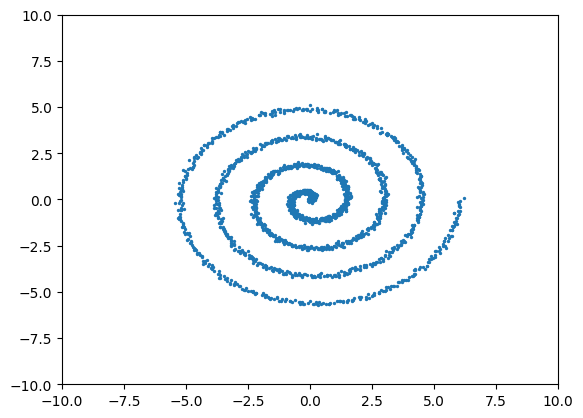

In [49]:
np.random.shuffle(x)
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.show()

In [50]:
# setting torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [132]:
noise_qubits = 2
code_qubits = 1
n_qubits = noise_qubits + code_qubits
n_layers = 7
BATCH_SIZE = 16
print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))

dev = qml.device("default.qubit", wires=n_qubits)
# dev = qml.device("ionq.simulator", wires=2)
# dev = qml.device("ionq.qpu", wires=2)

n_qubits = 3 n_layers = 7


In [133]:
def generator_init(generator_input):
    
    for i in range(n_qubits):
        qml.RY(generator_input[i]*np.pi, wires=i) # TODO: *a 해서 값 범위 맞추기

def generator_layer(params):
    for i in range(n_qubits):
        qml.RY(params[i][0], wires=i)
        qml.RX(params[i][1], wires=i)
        qml.RY(params[i][2], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    """
    quantum circuit node
    generator_input (np.array(큐빗)) : 생성기 입력 seed (noise + code)
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    마지막 측정은 모두 Z로
    """

    generator_init(generator_input)

    for param in params:
        generator_layer(param)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def generator_forward(params, generator_input):
    # 제너레이터 돌리고 결과 return하는 함수
    generator_output = [generator_circuit(params, single_in) for single_in in generator_input]
    generator_output = torch.stack(generator_output) # (BATCH_SIZE, n_qubits) 차원
    return generator_output[:, :noise_qubits], generator_output[:, noise_qubits:] # noise, code 순서로 반환


def generator_cost_fn(params, mine = False, qmine = False):

    generator_input = torch.rand((BATCH_SIZE, n_qubits)) * 2 - 1 # -1~1 사이의 랜덤한 값으로 초기화
    code_input = generator_input[:, -code_qubits:] # 입력중에서 code만 뽑는다. (BATCH_SIZE, code_qubits)

    generator_output, code_output = generator_forward(params, generator_input) # 출력을 뽑아낸다
    generator_output = generator_output.to(torch.float32)
    # print("code out shape = ", code_output.shape)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = torch.log(1-disc_output).mean()
    # print("gan_loss = ", gan_loss, gan_loss.shape)
    
    t = (code_input - code_output).pow(2).mean()
    gan_loss += t # code loss 추가
    # print("hmm", t, t.shape, code_input.shape, code_output.shape)
    # print("gan_loss = ", gan_loss, gan_loss.shape)

    if mine:
        gan_loss += 0 # TODO: mine loss 추가하기
    elif qmine:
        gan_loss += 0 # TODO: qmine loss 추가하기

    return gan_loss


def prediction(params, image, debug=False):
    prob_0 = 0
    prob_1 = 0
    for i in range(n_layers):
        prob_0 += circuit(params[:i+1], (image, 0))
        prob_1 += circuit(params[:i+1], (image, 1))

    if (debug):
        return (int(prob_0 <= prob_1), prob_0, prob_1)
    return int(prob_0 <= prob_1)

In [134]:
n_qubits

3

In [135]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=noise_qubits):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.LeakyReLU(),
            nn.Linear(400, 400),
            nn.LeakyReLU(),
            nn.Linear(400, 400),
            nn.LeakyReLU(),
            nn.Linear(400, 1),
            nn.Sigmoid())

        self.input_dim = input_dim

    def forward(self, x):
        if(len(x.shape) != 2):
            x = x.view(x.shape[0], -1)

        return self.layers(x)

disc_loss_fn = nn.BCELoss()

def disc_cost_fn(real_input, fake_input, smoothing=False):
    batch_num = real_input.shape[0]

    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    real_label = torch.ones((batch_num, 1)).to(device)
    fake_label = torch.zeros((batch_num, 1)).to(device)
    
    if smoothing:
        real_label = real_label - 0.3*torch.rand(real_label.shape).to(device)
    
    loss = 0.5 * (disc_loss_fn(disc_real, real_label) + disc_loss_fn(disc_fake, fake_label))
    
    return loss


In [136]:
generator_params = Variable(torch.tensor(np.random.normal(0, np.pi, (n_layers, n_qubits, 3))), requires_grad=True)
generator_opt = torch.optim.Adam([generator_params], lr=0.005)
print("parameter shape: ", generator_params.shape)

discriminator = LinearDiscriminator()

parameter shape:  torch.Size([7, 3, 3])


In [137]:
G_opt = torch.optim.Adam([generator_params], lr=2e-4)
D_opt = torch.optim.Adam(discriminator.parameters(), lr=2e-4)

In [138]:
epoch = 100
for rep in range(1, epoch+1):
    np.random.shuffle(x)
    iter_num = len(x) //BATCH_SIZE # 매번 50% 추출해서 학습. 셔플하니까 자투리 생기는건 무시.
    G_loss_sum = 0.0
    D_loss_sum = 0.0
    pbar = tqdm(range(iter_num))
    for i in pbar:
        batch = torch.FloatTensor(x[BATCH_SIZE * i : BATCH_SIZE * i + BATCH_SIZE])
        
        # train discriminator
        generator_seed = torch.rand((BATCH_SIZE, n_qubits)) * 2 - 1
        fake_input, _ = generator_forward(generator_params, generator_seed) # 저기 _도 나중에 mi 넣을때 필요
        fake_input = fake_input.to(torch.float32)
        disc_loss = disc_cost_fn(batch, fake_input)

        D_opt.zero_grad()
        disc_loss.requires_grad_(True)
        disc_loss.backward()
        D_opt.step()

        # train generator
        generator_loss = generator_cost_fn(generator_params, mine=False, qmine=False)
        G_opt.zero_grad()
        generator_loss.requires_grad_(True)
        generator_loss.backward()
        G_opt.step()

        D_loss_sum += disc_loss.item()
        G_loss_sum += generator_loss.item()

        pbar.set_postfix({'G_loss': G_loss_sum/(i+1), 'D_loss': D_loss_sum/(i+1)})


    print("epoch: {}, D_loss: {}, G_loss: {}".format(rep, D_loss_sum/iter_num, G_loss_sum/iter_num))

100%|██████████| 125/125 [01:51<00:00,  1.13it/s, G_loss=0.466, D_loss=0.275] 


epoch: 1, D_loss: 0.27480454081296923, G_loss: 0.46572360752150416


100%|██████████| 125/125 [01:52<00:00,  1.11it/s, G_loss=0.549, D_loss=0.184]


epoch: 2, D_loss: 0.1840662523508072, G_loss: 0.5494020092487335


 82%|████████▏ | 102/125 [01:29<00:20,  1.13it/s, G_loss=0.463, D_loss=0.182]